# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

## Part 1

In [16]:
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

not_alphanumeric_or_space = re.compile(r'[^(\w|\s|\d)]')
nlp = spacy.load('en_core_web_sm')

In [2]:
def preprocess(docs):
    docs_words = []
    for d in docs:
        docs1 = re.sub(not_alphanumeric_or_space, '', d.lower())
        docs2 = str(docs1).strip()
        docs3 = [token.lemma_ for token in nlp(docs2) if token.lemma_ != '-PRON-']
        docs4 = ' '.join(docs3)
        docs_words.append(docs4)   
    return(docs_words)

In [7]:
yelps = pd.read_csv('sentiment/yelps.csv')

vectorizer = TfidfVectorizer(min_df=20, 
                             max_df=.6, 
                             max_features=2000, 
                             use_idf=False, 
                             stop_words='english')

yelps = yelps.replace(['True','False'],[1,0])
yelps = yelps.replace('positive',1)
corpus = preprocess(yelps['text'].tolist())

y = yelps['positive'].tolist()
vectorizer.fit(corpus)

In [24]:
train_sizes = np.arange(0.01,0.75,0.01)
accuracy1 = []

for i in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(corpus, y, train_size=i, random_state=42)
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    LR = LogisticRegression()
    LR.fit(X_train,y_train)
    LR_pred = LR.predict(X_test)
    accuracy1.append(accuracy_score(y_test,LR_pred))

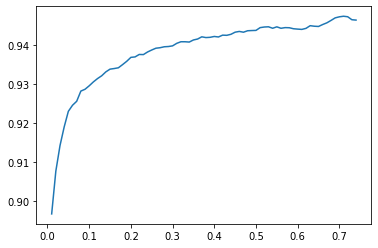

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_sizes, accuracy1)

## Part 2

In [29]:
import itertools
from gensim.models import Word2Vec

In [ ]:
docs_words = []
for doc in corpus:
    docs_words.append(doc.split(' '))

model = Word2Vec(docs_words, size=100, window=5, min_count=1,workers=3)

w2v_rep = np.zeros((len(corpus),s))
for i,doc in enumerate(docs_words):
    for word in doc:
        try:
            w2v_rep[i,:] += model.wv[word]
        except:
            None

w2v_rep = w2v_rep.tolist()
train_sizes = np.arange(0.1,0.8,0.1)
accuracy2 = []

for i in train_sizes:
    X_train, X_test, y_train, y_test = train_test_split(w2v_rep, y, train_size=i, random_state=42)
    LR2 = LogisticRegression(solver='liblinear')
    LR2.fit(X_train,y_train)
    LR_pred2 = LR2.predict(X_test)
    accuracy2.append(accuracy_score(y_test,LR_pred2))

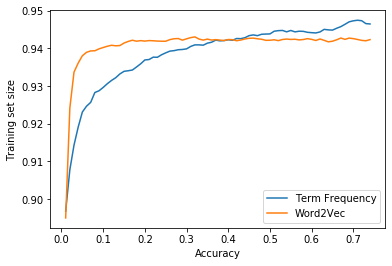

In [116]:
plt.plot(train_sizes, accuracy1,label='Term Frequency')
plt.plot(train_sizes,accuracy2,label='Word2Vec')
plt.legend()
plt.xlabel('Accuracy')
plt.ylabel('Training set size')
plt.show()

Therefore, with these parameters, it seems that Word2Vec does better for smaller training sets, but the previous term frequency algorithm catches up and does better after the training size exceeds about 40% the size of the dataset. I will next look at how the choice of parameters affects the accuracy. Note that the accuracy of either method here does not exceed 95%.

## Effect of Parameters

In [ ]:
all_acc = []
all_size = []
all_window = []
all_mincount = []
all_knegative = []
for s,w,m,n in itertools.product([100,300,500], [10,15,20], [1,3,5],[5,10,20]):
    docs_words = []
    for doc in corpus:
        docs_words.append(doc.split(' '))

    model = Word2Vec(docs_words, size=s, window=w, min_count=m, negative=n,workers=3)

    w2v_rep = np.zeros((len(corpus),s))
    for i,doc in enumerate(docs_words):
        for word in doc:
            try:
                w2v_rep[i,:] += model.wv[word]
            except:
                None

    w2v_rep = w2v_rep.tolist()
    train_sizes = np.arange(0.1,0.8,0.1)
    accuracy2 = []

    for i in train_sizes:
        X_train, X_test, y_train, y_test = train_test_split(w2v_rep, y, train_size=i, random_state=42)
        LR2 = LogisticRegression(solver='liblinear')
        LR2.fit(X_train,y_train)
        LR_pred2 = LR2.predict(X_test)
        accuracy2.append(accuracy_score(y_test,LR_pred2))
    
    all_acc.append(accuracy2)
    all_size.append(s)
    all_window.append(w)
    all_mincount.append(m)
    all_knegative.append(n)

In [180]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='blue', lw=4)]

### Size Parameter

The size here refers to the size of the vector of embeddings of the words. From the plot below, it seems that the larger sizes increase the accuracy of the algorithm, although the improvement is reduced at higher values (ie. the increase in accuracy when moving from size 300 to 500 is much smaller than the change in accuracy when moving from size 100 to 300). This seems to make sense since a larger size means more information about the word is stored, and the most significant information would be used in all cases, whereas the less important information would be used only when larger values of size are called for.

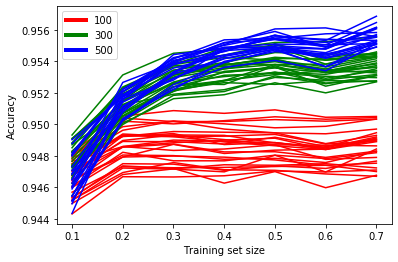

In [186]:
col={100:'red',300:'green',500:'blue'}
for i,j in enumerate(all_acc):
    plt.plot(train_sizes,j,c=col[all_size[i]])
plt.legend(custom_lines, ['100', '300', '500'])
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.show()

### Window Parameter

This refers to the number of words around the word of interest that are used in the training process. When the size parameter is 100, larger values of the window parameter improve the accuracy. However, at larger values of the size parameter, a window size of 15 or 20 perform about equally well. 

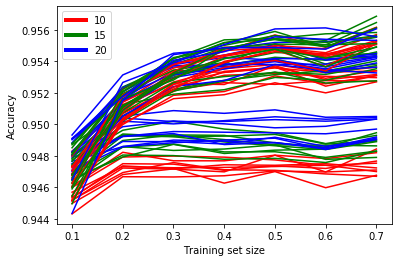

In [189]:
col={10:'red',15:'green',20:'blue'}
for i,j in enumerate(all_acc):
    plt.plot(train_sizes,j,c=col[all_window[i]])
plt.legend(custom_lines, ['10', '15', '20'])
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.show()

### min_count parameter

This parameter refers to the minimum frequency count that words need to have to be used in the analysis. By varying the parameter from 1 to 5, there is no significant effect on the accuracy. 

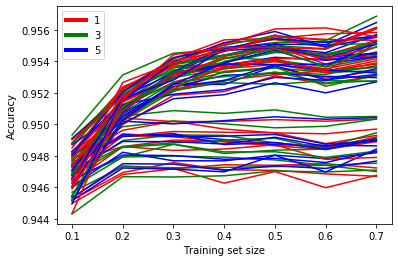

In [190]:
col={1:'red',3:'green',5:'blue'}
for i,j in enumerate(all_acc):
    plt.plot(train_sizes,j,c=col[all_mincount[i]])
plt.legend(custom_lines, ['1', '3', '5'])
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.show()

### K-negative Paramter

This parameter represents the number of 'noise words' chosen when maximizing the probability of a chosen word in the Word2Vec algorithm. There seems to be no significant effect of the choice of parameter here. 

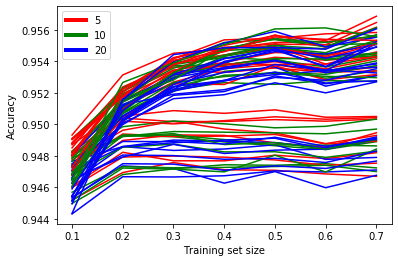

In [191]:
col={5:'red',10:'green',20:'blue'}
for i,j in enumerate(all_acc):
    plt.plot(train_sizes,j,c=col[all_knegative[i]])
plt.legend(custom_lines, ['5', '10', '20'])
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.show()

## Highest accuracy methods

In the plot below, all the methods used have average accuracy levels of at least 95%, which as we recall, is higher than the initial 2 methods we compared in section 1.2. In fact, there are 49 sets of parameters that could be used with the Word2Vec algorithm that achieve this level of accuracy. Nonetheless, note that the maximum accuracy does not exceed 0.958, so the improvement is not huge. 

In [197]:
high = [i for i,a in enumerate(all_acc) if np.mean(a)>0.95]
len(high)

49

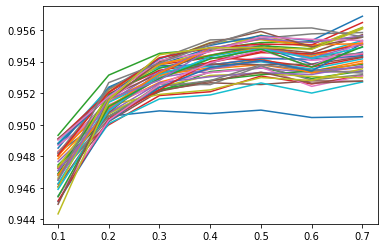

In [196]:
for j in high:
    plt.plot(train_sizes,all_acc[j])
plt.show()